# Irrigation circles near Biri-Manyame Dam, Zimbabwe, Summer 2023

In [2]:

import numpy as np
import os
from glob import glob


import rasterio as rio
from datetime import datetime

from eodag import EODataAccessGateway, setup_logging

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import matplotlib.colors

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

Set up working directory

In [50]:
workspace = "/tmp"
if not os.path.isdir(workspace):
    os.mkdir(workspace)

Configured eodag to download products in this workspace directory.

In [5]:
os.environ["EODAG__PEPS__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.abspath(workspace)

In [25]:
start_dt="2023-08-01"
end_dt ="2023-12-11"

In [26]:
setup_logging(2)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
geometry = "POLYGON ((30.154724 -17.548488, 30.154724 -17.457791, 30.273514 -17.457791, 30.273514 -17.548488, 30.154724 -17.548488))"
search_results, total_count = dag.search(
    productType="S2_MSI_L2A",
    geom=geometry,
    start=start_dt,
    end=end_dt,
    cloudCover=10,
)

2023-12-14 11:58:54,997 eodag.config                     [INFO    ] Loading user configuration from: /home/eoafrica/.config/eodag/eodag.yml
2023-12-14 11:58:55,155 eodag.core                       [INFO    ] usgs: provider needing auth for search has been pruned because no crendentials could be found
2023-12-14 11:58:55,156 eodag.core                       [INFO    ] aws_eos: provider needing auth for search has been pruned because no crendentials could be found
2023-12-14 11:58:55,156 eodag.core                       [INFO    ] meteoblue: provider needing auth for search has been pruned because no crendentials could be found
2023-12-14 11:58:55,157 eodag.core                       [INFO    ] hydroweb_next: provider needing auth for search has been pruned because no crendentials could be found
2023-12-14 11:58:55,306 eodag.core                       [INFO    ] Locations configuration loaded from /home/eoafrica/.config/eodag/locations.yml
2023-12-14 11:58:55,308 eodag.core              

Downloading only an early date and a late date of all products

In [34]:
search_results

SearchResult([EOProduct(id=S2B_MSIL2A_20230804T074619_N0509_R135_T35KRA_20230804T103843, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20230814T074619_N0509_R135_T35KRA_20230814T121147, provider=creodias_s3),
              EOProduct(id=S2A_MSIL2A_20230819T074621_N0509_R135_T35KRA_20230819T121858, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20230824T074619_N0509_R135_T35KRA_20230824T121240, provider=creodias_s3),
              EOProduct(id=S2A_MSIL2A_20230829T074621_N0509_R135_T35KRA_20230829T123128, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20230903T074619_N0509_R135_T35KRA_20230903T110250, provider=creodias_s3),
              EOProduct(id=S2A_MSIL2A_20230908T074621_N0509_R135_T35KRA_20230908T134558, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20230913T074619_N0509_R135_T35KRA_20230913T110829, provider=creodias_s3),
              EOProduct(id=S2A_MSIL2A_20230918T074611_N0509_R135_T35KRA_20230918T123401, provider=creodi

In [43]:
setup_logging(0)
dag.download_all(search_results)

['/tmp/S2B_MSIL2A_20230804T074619_N0509_R135_T35KRA_20230804T103843',
 '/tmp/S2A_MSIL2A_20230819T074621_N0509_R135_T35KRA_20230819T121858',
 '/tmp/S2A_MSIL2A_20230829T074621_N0509_R135_T35KRA_20230829T123128',
 '/tmp/S2A_MSIL2A_20230908T074621_N0509_R135_T35KRA_20230908T134558',
 '/tmp/S2A_MSIL2A_20230918T074611_N0509_R135_T35KRA_20230918T123401',
 '/tmp/S2A_MSIL2A_20230928T074711_N0509_R135_T35KRA_20230928T112354',
 '/tmp/S2B_MSIL2A_20230814T074619_N0509_R135_T36KTF_20230814T121147',
 '/tmp/S2B_MSIL2A_20230824T074619_N0509_R135_T36KTF_20230824T121240',
 '/tmp/S2B_MSIL2A_20230903T074619_N0509_R135_T36KTF_20230903T110250',
 '/tmp/S2A_MSIL2A_20230918T074611_N0509_R135_T36KTF_20230918T123401',
 '/tmp/S2B_MSIL2A_20230814T074619_N0509_R135_T35KRA_20230814T121147',
 '/tmp/S2B_MSIL2A_20230903T074619_N0509_R135_T35KRA_20230903T110250',
 '/tmp/S2B_MSIL2A_20230923T074629_N0509_R135_T35KRA_20230923T104033',
 '/tmp/S2A_MSIL2A_20230819T074621_N0509_R135_T36KTF_20230819T121858',
 '/tmp/S2A_MSIL2A_20

In [58]:
first_date = search_results[0]
last_date = search_results[-1]
selected_results = [first_date, last_date]
selected_results

[EOProduct(id=S2B_MSIL2A_20230804T074619_N0509_R135_T35KRA_20230804T103843, provider=creodias_s3),
 EOProduct(id=S2B_MSIL2A_20230923T074629_N0509_R135_T36KTF_20230923T104033, provider=creodias_s3)]

We quickly sort the results by date to plot the images before the fire first and the images after the fire last.

While doing so, we already use the library rasterio to read the image into a numpy array.

Since matplotlib expects the z-axis that represents the image bands (red, green and blue) to be the first dimension, we need to re-arrange the dimensions before plotting the images by using numpy.transpose.

In [68]:
os.listdir("/tmp/S2B_MSIL2A_20230913T074619_N0509_R135_T35KRA_20230913T110829/GRANULE/L2A_T35KRA_A034052_20230913T081202/IMG_DATA/R10m")

['T35KRA_20230913T074619_AOT_10m.jp2',
 'T35KRA_20230913T074619_B02_10m.jp2',
 'T35KRA_20230913T074619_B04_10m.jp2',
 'T35KRA_20230913T074619_TCI_10m.jp2',
 'T35KRA_20230913T074619_B08_10m.jp2',
 'T35KRA_20230913T074619_WVP_10m.jp2',
 'T35KRA_20230913T074619_B03_10m.jp2']

Calculate the TCI and NDVI

In [110]:
search_results_kv_tci = {}
search_results_kv_ndvi = {}
for result in selected_results:
    # getting the date of aquisition
    publication_date_str = result.properties.get("publicationDate", "")
    publication_date = datetime.strptime(publication_date_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    if glob(os.path.join(workspace, f"*{publication_date.strftime('%Y%m%d')}*")): 
        print(publication_date.strftime('%Y%m%d'))
        tci = glob(os.path.join(workspace, f"S2*_MSIL2A*{publication_date.strftime('%Y%m%d')}*", "GRANULE", "L2A*", "IMG_DATA", "R10m", f"*{publication_date.strftime('%Y%m%d')}*TCI_10m.jp2"))[0]
        with rio.open(tci) as src:
            tci_array = src.read()
        transposed_tci = np.transpose(tci_array, (1, 2, 0))
        roi = transposed_tci[3300:4500, 3800:4600]
        search_results_kv_tci[result.properties["publicationDate"]] = roi
        
        # caculating NDVI, RED is B4, NIR is B8
        nir_band = glob(os.path.join(workspace, f"S2*_MSIL2A*{publication_date.strftime('%Y%m%d')}*", "GRANULE", "L2A*", "IMG_DATA", "R10m", "*B08*.jp2"))[0]
        red_band = glob(os.path.join(workspace, f"S2*_MSIL2A*{publication_date.strftime('%Y%m%d')}*", "GRANULE", "L2A*", "IMG_DATA", "R10m", "*B04*.jp2"))[0]
        with rio.open(nir_band) as nir_src:
            nir_array = nir_src.read()
        with rio.open(red_band) as red_src:
            red_array = red_src.read()
        # NDVI = (NIR - RED) / (NIR + RED)
        ndvi_array = (nir_array - red_array) / (nir_array + red_array)

        # Getting the ROI; region of interest
        ndvi_roi = ndvi_array[:, 3300:4500, 3800:4600]
        transposed_ndvi = np.transpose(ndvi_roi, (1, 2, 0))
        search_results_kv_ndvi[result.properties["publicationDate"]] = transposed_ndvi


20230804
20230923


In [108]:
search_results_kv_tci

{'2023-08-04T14:16:12.570Z': array([], shape=(800, 10980, 0), dtype=uint8),
 '2023-09-23T13:34:34.175Z': array([], shape=(800, 10980, 0), dtype=uint8)}

NBR = (NIR-SWIR)/(NIR+SWIR)
The Normalized Burn Ratio calculation is used to highlight burned areas and to estimate severity of fire. Burned areas reflect high in shortwave infrared (SWIR) and low in near infrared (NIR) and will therefore have a low NBR value. Similar to NDVI, healthy vegetation will have a high NBR value. The band numbers (B8, B12) are based on Sentinel 2 MSI band designations, but the formula may be used for any imagery by specifying the NIR band as B4 and the SWIR band as B6 in the subsequent dialog.

NBRI (Sentinel 2 MSI): NIR=B8, SWIR/Thermal=B12

Text(0.5, 1.0, 'TCI 2023-09-23T13:34:34.175Z - Cloud masked')

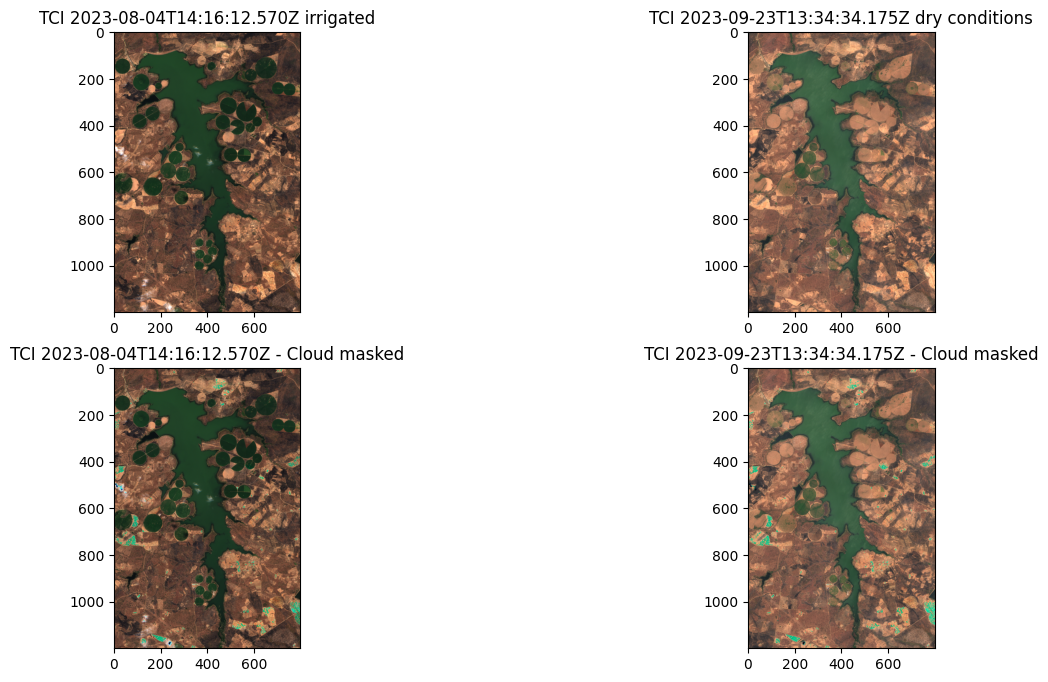

In [122]:
image1 = search_results_kv_tci[list(search_results_kv_tci)[0]]
image2 = search_results_kv_tci[list(search_results_kv_tci)[-1]]
scl_masked = (image1 != 255) & (image2 != 255)

masked_image1 = np.where(scl_masked, image1, 0)
masked_image2 = np.where(scl_masked, image2, 0)
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.imshow(image1)
plt.title(f'TCI {list(search_results_kv_tci)[0]} irrigated')

plt.subplot(2, 2, 2)
plt.imshow(image2)
plt.title(f'TCI {list(search_results_kv_tci)[-1]} dry conditions')

plt.subplot(2, 2, 3)
plt.imshow(masked_image1)
plt.title(f'TCI {list(search_results_kv_tci)[0]} - Cloud masked')

plt.subplot(2, 2, 4)
plt.imshow(masked_image2)
plt.title(f'TCI {list(search_results_kv_tci)[-1]} - Cloud masked')

Masking out water class and clouds for comparing the images

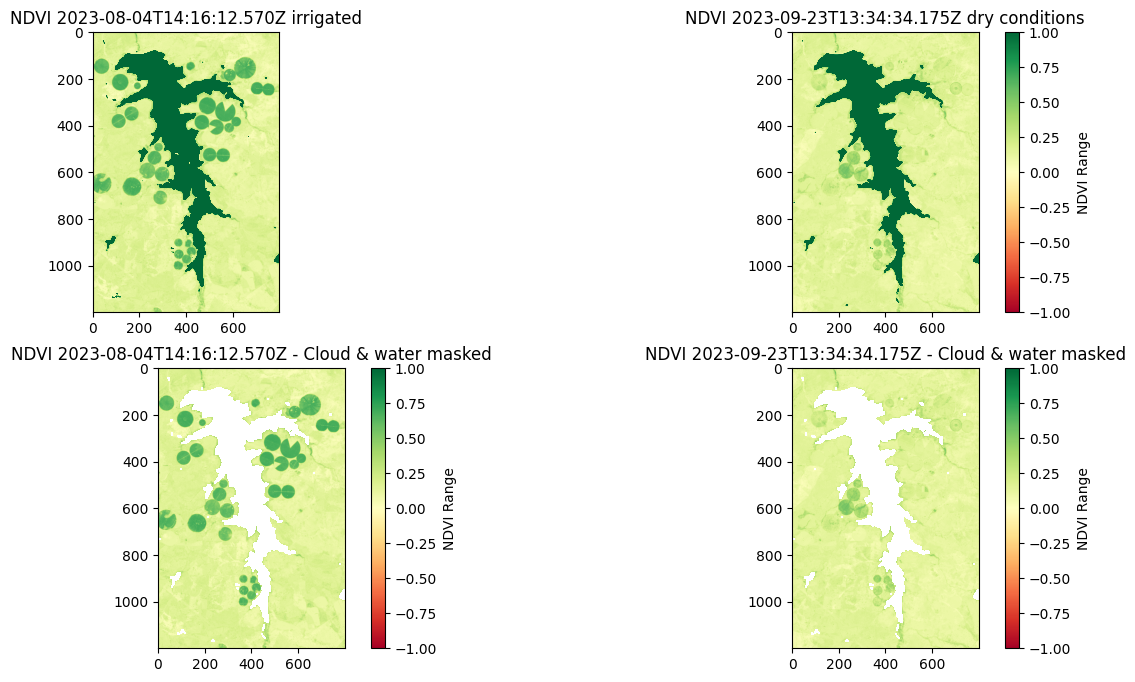

In [183]:
image1_ndvi = search_results_kv_ndvi[list(search_results_kv_ndvi)[0]]
image2_ndvi = search_results_kv_ndvi[list(search_results_kv_ndvi)[-1]]
scl_masked = (image1 != 255) & (image2 != 255)

masked_image1_scl = np.where(scl_masked, image1, np.nan)
masked_image2_scl= np.where(scl_masked, image2, np.nan)
# mask out water:
water_masked = (image1 <=  1)& (image2 <=  1)

masked_image1_ndvi = np.where(water_masked, masked_image1_scl, np.nan)
masked_image2_ndvi = np.where(water_masked, masked_image2_scl, np.nan)

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.imshow(image1, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title(f'NDVI {list(search_results_kv_tci)[0]} irrigated')

plt.subplot(2, 2, 2)
plt.imshow(image2, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title(f'NDVI {list(search_results_kv_tci)[-1]} dry conditions')
plt.colorbar(label='NDVI Range')

plt.subplot(2, 2, 3)
plt.imshow(masked_image1_ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title(f'NDVI {list(search_results_kv_tci)[0]} - Cloud & water masked')
plt.colorbar(label='NDVI Range')
plt.subplot(2, 2, 4)
plt.imshow(masked_image2_ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title(f'NDVI {list(search_results_kv_tci)[-1]} - Cloud & water masked')
plt.colorbar(label='NDVI Range')

Calculate the differnces in the NDVI images

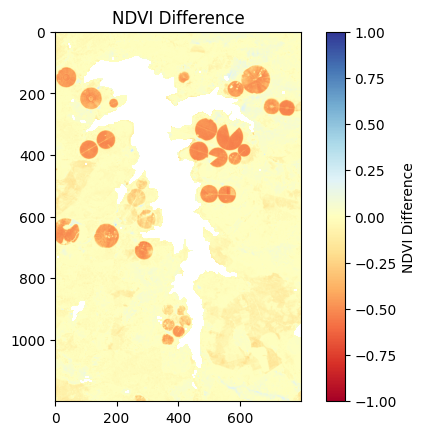

In [184]:
ndvi_difference = masked_image2_ndvi -  masked_image1_ndvi

plt.imshow(ndvi_difference, cmap='RdYlBu', vmin=-1, vmax=1) 
plt.title('NDVI Difference')
plt.colorbar(label='NDVI Difference')
plt.show()

Comparing the two images from the beginning of August 2023 to the end of September 2023:
Red Areas: Typically indicate a decrease in vegetation while looking at negative values. This could be due to factors such as loss of vegetation, stress, or damage and especially in this case, missing irrigation. The darker the red color, the more significant the decrease.

Blue Areas: Typically indicate an increase in vegetation while looking at positived values. This could be due to factors such as new growth, improved health, or increased density of vegetation. The darker the blue, the more significant the increase. However, there are mainly red/decresing changes visible. 

## Anaylsis with S1

Since there are so many clouds, an analysis with SAR data would be more sufficient 

In [185]:
setup_logging(2)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
geometry =  "POLYGON ((30.154724 -17.548488, 30.154724 -17.457791, 30.273514 -17.457791, 30.273514 -17.548488, 30.154724 -17.548488))"
search_results_s1, total_count = dag.search(
    productType="S1_SAR_GRD",
    geom=geometry,
    start=start_dt,
    end=end_dt,
)

2023-12-14 13:45:17,048 eodag.config                     [INFO    ] Loading user configuration from: /home/eoafrica/.config/eodag/eodag.yml
2023-12-14 13:45:17,206 eodag.core                       [INFO    ] usgs: provider needing auth for search has been pruned because no crendentials could be found
2023-12-14 13:45:17,207 eodag.core                       [INFO    ] aws_eos: provider needing auth for search has been pruned because no crendentials could be found
2023-12-14 13:45:17,208 eodag.core                       [INFO    ] meteoblue: provider needing auth for search has been pruned because no crendentials could be found
2023-12-14 13:45:17,208 eodag.core                       [INFO    ] hydroweb_next: provider needing auth for search has been pruned because no crendentials could be found
2023-12-14 13:45:17,369 eodag.core                       [INFO    ] Locations configuration loaded from /home/eoafrica/.config/eodag/locations.yml
2023-12-14 13:45:17,372 eodag.core              

In [186]:
sorted_search_results_s1 = sorted(search_results_s1, key=lambda x: datetime.strptime(x.properties.get("publicationDate", ""), '%Y-%m-%dT%H:%M:%S.%fZ'))
sorted_search_results_s1

[]

In [10]:
setup_logging(0) 
dag.download_all(sorted_search_results_s1)

['/tmp/S1B_IW_GRDH_1SDV_20210507T162007_20210507T162032_026800_03339D_A0B5',
 '/tmp/S1B_IW_GRDH_1SDV_20210509T034431_20210509T034456_026822_033442_3ED7',
 '/tmp/S1B_IW_GRDH_1SDV_20210519T162007_20210519T162032_026975_03390E_B9F2',
 '/tmp/S1B_IW_GRDH_1SDV_20210521T034431_20210521T034456_026997_0339AB_9402',
 '/tmp/S1A_IW_GRDH_1SDV_20210527T034526_20210527T034555_038068_047E2D_7C16',
 '/tmp/S1B_IW_GRDH_1SDV_20210531T162033_20210531T162104_027150_033E41_095D',
 '/tmp/S1B_IW_GRDH_1SDV_20210602T034446_20210602T034511_027172_033EDC_65DE',
 '/tmp/S1B_IW_GRDH_1SDV_20210507T162032_20210507T162103_026800_03339D_C6A2',
 '/tmp/S1B_IW_GRDH_1SDV_20210519T162032_20210519T162103_026975_03390E_464F',
 '/tmp/S1B_IW_GRDH_1SDV_20210531T162008_20210531T162033_027150_033E41_6FE0',
 '/tmp/S1A_IW_GRDH_1SDV_20210606T162110_20210606T162135_038221_0482BF_E09F',
 '/tmp/S1A_IW_GRDH_1SDV_20210513T162109_20210513T162134_037871_04783E_6A8D',
 '/tmp/S1B_IW_GRDH_1SDV_20210602T034421_20210602T034446_027172_033EDC_9BDC',

Getting S1 VV/ VH files, Plotting the data and zooming to the dam

In [187]:
zoomed_results_kv_s1 = {}
for result in sorted_search_results_s1:
    # getting the date of aquisition
    publication_date_str = result.properties.get("publicationDate", "")
    publication_date = datetime.strptime(publication_date_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    date_format = "%Y-%m-%d"
    if datetime.strptime(start_dt, date_format) <= publication_date <= datetime.strptime(end_dt, date_format):
 
        if glob(os.path.join('/tmp', f"S1A_IW_GRDH_1SDV_*{publication_date.strftime('%Y%m%d')}*")):
            s1_vv = glob(os.path.join('/tmp', f"S1A_IW_GRDH_1SDV_*{publication_date.strftime('%Y%m%d')}*", 'measurement', '*vv*'))[0]
            s1_vh = glob(os.path.join('/tmp', f"S1A_IW_GRDH_1SDV_*{publication_date.strftime('%Y%m%d')}*", 'measurement', '*vh*'))[0]
            print(s1)
            with rio.open(s1) as src:
                s1_array = src.read()
                s1_array = np.flip(s1_array, axis=1)
                print(s1_array.shape)
                roi = s1_array[:, 14000:19000, 6000:8000]
            transposed_s1 = np.transpose(roi, (1, 2, 0))
            plt.imshow(transposed_s1, cmap='gray', vmin=0, vmax=255)
            plt.title(f'S1 GRD VH, Date: {publication_date_str}')
            plt.show()
            zoomed_results_kv_s1[result.properties["publicationDate"]] = transposed_s1

Choosing an image before and after the vulcano event to get the differences

In [13]:
image1 = zoomed_results_kv_s1['...']
image2 = zoomed_results_kv_s1['..Z']


In [14]:
def plot_sentinel1_difference(before, after, threshold=0):
    """
    Plot the difference between two Sentinel-1 images.
    """
    # Checking that both arrays have the same shape
    min_rows = min(before.shape[0], after.shape[0])
    min_cols = min(before.shape[1], after.shape[1])

    before = before[:min_rows, :min_cols, :]
    after = after[:min_rows, :min_cols, :]
    difference = before - after
    # Apply thresholding to highlight changes
    masked_difference = np.where(difference <= threshold, 0, difference)
    plt.figure(figsize=(20, 15))

    plt.subplot(1, 3, 1)
    plt.imshow(before, cmap='gray', vmin=0, vmax=255)
    plt.title('Before the eruption')

    plt.subplot(1, 3, 2)
    plt.imshow(after, cmap='gray', vmin=0, vmax=255)
    plt.title('After the eruption')

    plt.subplot(1, 3, 3)
    plt.imshow(masked_difference, cmap='coolwarm', vmin=np.nanmin(masked_difference), vmax=np.nanmax(masked_difference))
    plt.title('Difference (After - Before)')
    plt.colorbar(shrink=0.1)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_sentinel1_difference(image1, image2, threshold = 0)

In the comparison of the images before and after the volcano eruption, a distinct pattern is evident in the difference image. The blue regions indicate lower values (negative values) after the eruption event. This effect is particularly pronounced in the lava flow area, where the negative values suggest possible removal of vegetation due to the lava. The distinct pattern in the difference S1 VH image provides clear visual evidence of the changes caused by the eruption.
